# Starbucks - XGBoost

    Udacity - Machine Learning Engineer Nanodegree Program
    Author: Leonardo Simões
    
**Here the XGBoost algorithm will be used to perform a multilabel classification of the type of offer. The dataset used will only be 'offers'. At the end of the process, the accuracy of the model will be calculated.**

In [1]:
# imports
import os
import numpy as np
import pandas as pd
import boto3
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri 
import matplotlib.pyplot as plt
#from sagemaker.xgboost.estimator import XGBoost

## AWS Sagemaker configurations

In [3]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [4]:
# should be the name of directory you created to save your features data
data_dir = 'data'

# set prefix, a descriptive name for a directory  
prefix = 'data'

# upload all data to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
input_data

's3://sagemaker-sa-east-1-377572488885/data'

In [5]:
output_path = 's3://{}/{}'.format(bucket, prefix)
output_path

's3://sagemaker-sa-east-1-377572488885/data'

## Train and test data

In [6]:
# confirm that data is in S3 bucket
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')

data/X_test.csv
data/X_train.csv
data/offers.csv
data/offers_ml.csv
data/portfolio.json
data/profile.json
data/train.csv
data/transactions.csv
data/transcript.json
data/y_test.csv
data/y_train.csv
Test passed!


In [16]:
x_test_path = output_path + '/X_test.csv'
x_test = pd.read_csv(x_test_path, names=None, dtype='float32')
x_test.head()

,reward,difficulty,duration,mobile,social,web
0,5.0,5.0,5.0,1.0,1.0,1.0
1,10.0,10.0,5.0,1.0,1.0,1.0
2,5.0,5.0,5.0,1.0,1.0,1.0
3,5.0,5.0,5.0,1.0,1.0,1.0
4,0.0,0.0,3.0,1.0,1.0,0.0


In [17]:
test_x_np = x_test.to_numpy()
test_x_np

array([[ 5.,  5.,  5.,  1.,  1.,  1.],
       [10., 10.,  5.,  1.,  1.,  1.],
       [ 5.,  5.,  5.,  1.,  1.,  1.],
       ...,
       [ 3.,  7.,  7.,  1.,  1.,  1.],
       [10., 10.,  7.,  1.,  1.,  0.],
       [10., 10.,  7.,  1.,  1.,  0.]], dtype=float32)

In [18]:
y_test_path = output_path + '/y_test.csv'
y_test = pd.read_csv(y_test_path, names=None, dtype='float32')
y_test.head()

,offer_label
0,1.0
1,1.0
2,1.0
3,1.0
4,0.0


In [19]:
test_y_np = y_test.iloc[:,0].to_numpy()
test_y_np

array([1., 1., 1., ..., 2., 1., 1.], dtype=float32)

## Train model

In [7]:
container = get_image_uri(boto3.Session().region_name,
                          'xgboost', 
                          repo_version='1.0-1')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [8]:
xgb = sagemaker.estimator.Estimator(image_name=container, 
                                    role = role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path=output_path,
                                    sagemaker_session=sagemaker_session)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [12]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='multi:softmax',
                        num_round=100,
                        num_class=3)

In [22]:
#formatted_train_data = xgb.record_set(train_x_np, labels=train_y_np)

AttributeError: 'Estimator' object has no attribute 'record_set'

In [36]:
#s3_input_train = sagemaker.s3_input(s3_data=output_path, content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [39]:
#s3_input_train2 = sagemaker.s3_input(s3_data=output_path + '/train.csv', content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [10]:
s3_input_train3 = sagemaker.s3_input(s3_data=input_data + '/train.csv', content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [13]:
%%time
xgb.fit({'train': s3_input_train3});

2020-10-21 20:47:42 Starting - Starting the training job...
2020-10-21 20:47:45 Starting - Launching requested ML instances......
2020-10-21 20:48:49 Starting - Preparing the instances for training......
2020-10-21 20:49:50 Downloading - Downloading input data...
2020-10-21 20:50:28 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[20:50:51] 111324x6 matrix with 667944 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Single node training.
INFO:root:Train matrix has 111324 rows
[20:50:51] WAR

In [15]:
%%time
# deploy your model to create a predictor
predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!CPU times: user 271 ms, sys: 7.98 ms, total: 279 ms
Wall time: 7min 32s


In [28]:
from sagemaker.predictor import csv_serializer

predictor.content_type = 'text/csv'
predictor.serializer = csv_serializer
predictor.deserializer = None

In [30]:
s3_input_test = sagemaker.s3_input(s3_data=input_data + '/X_test.csv', content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [37]:
test_preds = predictor.predict(x_test.values).decode('utf-8')

In [42]:
test_y_preds = np.fromstring(test_preds, sep=',')
test_y_preds

array([1., 1., 1., ..., 2., 1., 1.])

In [43]:
# test that your model generates the correct number of labels
assert len(test_y_preds)==len(test_y_np), 'Unexpected number of predictions.'
print('Test passed!')

Test passed!


## Model evaluation

In [46]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_y_np, test_y_preds, normalize=True)
print(accuracy)

print('\nPredicted class labels: ')
print(test_y_preds)
print('\nTrue class labels: ')
print(test_y_np)

1.0

Predicted class labels: 
[1. 1. 1. ... 2. 1. 1.]

True class labels: 
[1. 1. 1. ... 2. 1. 1.]


In [48]:
pip install mlxtend

     |████████████████████████████████| 1.3 MB 6.9 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [50]:
#contrução da matriz de confusão
from sklearn.metrics import classification_report, confusion_matrix
matriz_confusao = confusion_matrix(test_y_np, test_y_preds)
print(matriz_confusao)

[[ 5621     0     0]
 [    0 16045     0]
 [    0     0 15442]]


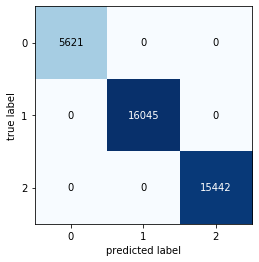

In [51]:
#realiza o plot da matriz de confusão
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao)
plt.show()

## Delete endpoint and empty bucket

In [ ]:
#delete endpoint
predictor.delete_endpoint()

In [ ]:
# deleting bucket
bucket_to_delete = boto3.resource('s3').Bucket(bucket)
bucket_to_delete.objects.all().delete()